# Transcription x MIDI

This notebook describes a query transcription x MIDI melody strategy for query-by-humming. A query is matched against classified MIDI files representing melodies. Results are sorted by the match scores.

Queries are transcribed to MIDI and matched using SMBGT. Following cells will show and explain every step for the experiment.

## Initialize libraries and functions

The cell bellow initialize functions and import libraries that will be used throughout the experiment.

In [1]:
import argparse
import csv
import vamp
import librosa
import os
import numpy as np
from scipy.signal import convolve
from midiutil.MidiFile import MIDIFile
import scipy.signal as sig
from scipy.signal import argrelextrema
from scipy.signal import medfilt
import scipy
import matplotlib.pyplot as plt
import qbhlib as ql

# Convert an array of Hz elements to Midi scale.
def hz2midi(hz):
    hz_nonneg = hz.copy()
    midi = np.zeros(len(hz))
    midi[hz > 0] = 69 + 12*np.log2(hz_nonneg[hz > 0]/440.)

    return midi

def write_temp_midi(notes):
    track = 0
    time = 0
    tempo = 130
    midifile = MIDIFile(1, adjust_origin=False)

    # Add track name and tempo.
    midifile.addTrackName(track, time, "MIDI TRACK")
    midifile.addTempo(track, time, tempo)

    channel = 0
    volume = 100
    for note in notes:
        onset = note[0] * (tempo/60.)
        duration = note[1] * (tempo/60.)
        pitch = int(note[2])
        midifile.addNote(track, channel, pitch, onset, duration, volume)
    binfile = open('temp.mid', 'wb')
    midifile.writeFile(binfile)
    binfile.close()
    os.system('midicsv temp.mid > temp.csv')
    
def updatequeue(S, best, K, track):
    for i in range(K):
        if S[i]['score'] < best:
            S.insert(i,{'score': best, 'track': track})
            S.pop()
            return    

def search_query(query):
    Q = query[0]
    best = 0
    if len(Q)>0:
        S = []
        for pos in range(K):
            S.append({'score':-10,'track': [[],'0']})
        for song in DB:
            best = 0
            X = song[0]
            if mode == 'smbgt':
                best = ql.smbgt(Q, X, 0, 0, 99.0, 0.3, 0.2, 0.0, 0, 1)
            if mode == 'dtw':
                D, wp = dtw(Q, X, subseq=False)

                W = np.zeros((len(Q),len(X)))
                for i in range(len(Q)):
                    for j in range(len(X)):
                        W[i,j] = 1/((max(i,j)+1)/max(len(Q), len(X)))
                E = D*W
                best = np.min(E[round(len(Q)/2):,:])
            updatequeue(S, best, K, song[1])
        res = list(filter(lambda e: e['track'] == query[1], S))
        if len(res)<1:
            return 0
        else:
            return 1.0/(S.index(res[0])+1.0)
    return 0

## Extract F0

The first step of the experiment extracts F0 vector from the wav file. 

Below, we see the F0 vector extracted, after being scaled to MIDI notes. We also plot the melody as present in the MIDI file for reference. The following steps will try to transform this vector to a MIDI file.

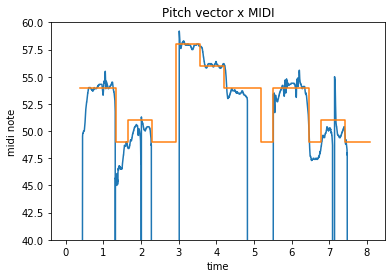

In [39]:
import librosa, vamp

data, sr = librosa.load('00017.wav', sr=8000, mono=True)
melody = vamp.collect(data, sr, "mtg-melodia:melodia")
pitch_array = melody['vector'][1]
midi_array = hz2midi(pitch_array)
plt.plot((np.arange(len(midi_array))/len(midi_array)*8), midi_array)
plt.ylim(40,60)
plt.title('Pitch vector x MIDI')

ground_truth = np.genfromtxt('00017.csv')
plt.step(0.2+(250+ground_truth[:,0])/11560.0*7.722,ground_truth[:,1]-7, where='post')
plt.xlabel('time')
plt.ylabel('midi note')
plt.show()

## Transcription to MIDI

This cell shows the process of transcribing F0 vector to MIDI. 

In the plot, we see the obtained MIDI compared to the reference MIDI from the dataset.

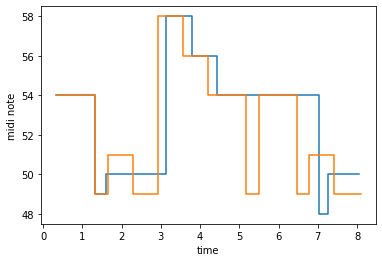

In [106]:
import warnings
warnings.filterwarnings('ignore')

filter_duration = 0.2
hop = sr*0.0029
transition = 1.0/(0.0005*sr)
rate = float(hop)/sr
filter_size = int(filter_duration * sr / float(hop))
if filter_size % 2 == 0:
    filter_size += 1
nonzero = np.nonzero(midi_array)
midi_filt = np.zeros(len(midi_array))
midi_filt[nonzero] = convolve(midi_array[nonzero], np.ones(filter_size)/filter_size)[int(filter_size/2):-int(filter_size/2)]
midi_filt[np.where(np.abs(np.diff(midi_filt))>transition)[0]] = -10

up = np.where(midi_filt[1:]-midi_filt[:-1]>24)[0]
down = np.where(midi_filt[1:]-midi_filt[:-1]<-24)[0]
if len(up)>len(down):
    up = up[:-1]
if len(up)<len(down):
    down = down[1:]
len_sec = (down-up)/(sr/float(hop))
small_contours = np.where(len_sec<0.1)[0]
for e in small_contours:
    midi_filt[up[e]:down[e]+1]=-10
midi_filt = np.round(midi_filt)

minduration = filter_duration
notes = []
p_prev = -2
duration = 0
onset = 0
initial_note = 0
true_initial_note = 0
notes_out = []

for n, p in enumerate(midi_filt):
    if abs(p-p_prev)<2:
        if(duration == 1): onset = n
        duration += 1
    else:
        # treat 0 as silence
        if p_prev != None and p_prev > 0:
            # add note
            duration_sec = duration * rate
            # only add notes that are long enough
            if duration_sec >= minduration:
                onset_sec = (onset-initial_note) * rate
                if(len(notes)==0): 
                    initial_note = onset
                    onset_sec = (onset-initial_note) * rate
                elif(onset_sec-(notes[-1][0]+notes[-1][1])>1): 
                    notes = []
                    initial_note = onset
                    onset_sec = (onset-initial_note) * rate
                note = midi_filt[onset:onset+duration]
                median = scipy.stats.mode(note[np.where(note>0)])[0]
                notes.append((onset_sec, duration_sec, median))
                if(len(notes)>len(notes_out)):
                    notes_out = notes
                    true_initial_note = initial_note

        if p_prev != None and p_prev == -10 and p == 0 and len(notes)>0:
            onset_sec = (onset-initial_note) * rate
            duration_sec = duration * rate
            if notes[-1][0]!=onset_sec and duration_sec>=minduration:
                note = midi_filt[onset:onset+duration]
                median = scipy.stats.mode(note[np.where(note>0)])[0]
                if(median!=[]): notes.append((onset_sec, duration_sec, median))
            else:
                new_note = np.asarray(notes[-1])
                new_note[1] = new_note[1]+duration*rate
                notes[-1] = tuple(new_note)

        if not (p_prev != None and p_prev == -10 and p > 0):
            # start new note
            onset = n
            duration = 1
        p_prev = p

if p_prev > 0:
    duration_sec = duration * rate
    if duration_sec >= minduration:
        onset_sec = onset * rate
        notes.append((onset_sec, duration_sec, p_prev))
write_temp_midi(notes_out)
temp_midi = np.genfromtxt('temp.csv', invalid_raise=False, dtype="S5,S6,S10,S5,S5,S5")
x = np.array([int(i[1].decode('utf-8')[:-1]) for i in temp_midi[1:]])
y = np.array([int(i[4].decode('utf-8')[:-1]) for i in temp_midi[1:]])
plt.step(0.2+(250+x)/14385.0*7.722,y, where='post')



ground_truth = np.genfromtxt('00017.csv')
plt.step(0.2+(250+ground_truth[:,0])/11560.0*7.722,ground_truth[:,1]-7, where='post')
plt.title('Transcription x MIDI')
plt.xlabel('time')
plt.ylabel('midi note')
plt.show()

## Taking Intervals

To avoid the inability of matching queries to MIDI of different reference tone, 
we derivate the time series, obtaining a sequence of intervals.

In [117]:
gen_int=True
gen_ioir=False
f = open('temp.csv', 'r')
parsed = csv.reader(f, delimiter=',')
events = []
notes = []
durations = []
onsets = []
last_time = None
last_note = None
for row in parsed:
    if row[2]==' Header':
        ppqn = int(row[5])
    if row[2]==' Tempo':
        tempo = int(row[3])
    if row[2]==' Note_on_c':
        time = int(row[1])
        note = int(row[4])
        is_on = bool(int(row[5]))
        if not is_on:
            events+=[[time-last_time,note]]
            notes+=[note]
            durations+=[time-last_time]
            onsets+=[time]
            #events+=[note]*(time-len(events))
        if(last_time==None or last_note==note): last_time = time
        last_note = note
    if row[2]==' Note_off_c':
        time = int(row[1])
        note = int(row[4])
        is_on = False
        events+=[[time-last_time,note]]
        notes+=[note]
        durations+=[time-last_time]
        onsets+=[time]
        last_time = time
events = np.asarray(events)
notes = np.asarray(notes)
durations = np.asarray(durations)
onsets = np.asarray(onsets)
intervals = notes[1:]-notes[:-1]
if gen_ioir:
    main_onsets = onsets
    ioi = main_onsets[1:]-main_onsets[:-1]
    ioir = np.log2(ioi[1:]/ioi[:-1])
    np.save('00017.ioir', ioir)
if gen_int:
    intervals = intervals[np.nonzero(intervals)]
    print('Interval sequence:', intervals)
    np.save('00017.int', intervals)

Interval sequence: [-5  1  8 -2 -2 -6  2]


In [2]:
import glob
from multiprocessing import Pool
from math import ceil

query_files = glob.glob("/app/dataset/wav/**/**/*.int.npy")
db_files = "/app/dataset/mid/*.mid.int.npy"
outfile = "log"
K = 10
mode = 'smbgt'
queries = []
DB = []

print('\nLoading queries...')
for i in range(len(query_files)):
    queries.append([np.load(query_files[i]), query_files[i][-17:-12]])

print('Loading db...')
for file in glob.glob(db_files):
    DB.append([np.load(file), file[-17:-12]])

f = open(outfile, 'a')
f.write(' '.join([db_files, str(K), '\n']))

with Pool(processes=10) as pool:
    res = pool.map(search_query, queries)
    mrr = sum(res)/len(queries)
    recall = sum(map(ceil,res))/len(queries)
a = '\t'.join(('Recall: '+str(recall),'MRR: '+str(mrr),'\n'))
print(a)
f.write(a)


Loading queries...
Loading db...
Recall: 0.06612502821033626	MRR: 0.03342038237095786	



54